FANOVA PLOTS

/home/misgana/remote/AutoDA/notebooks/../..
path /home/misgana/remote/AutoDA/notebooks/../../AutoData


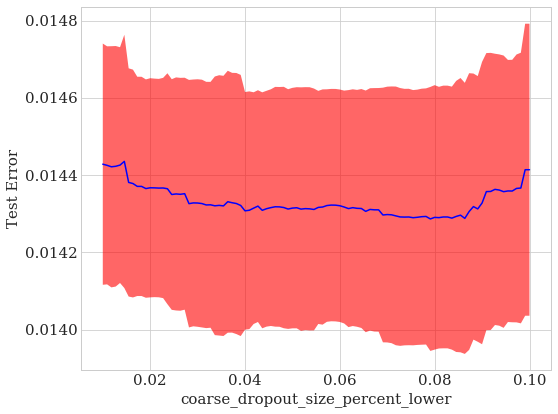

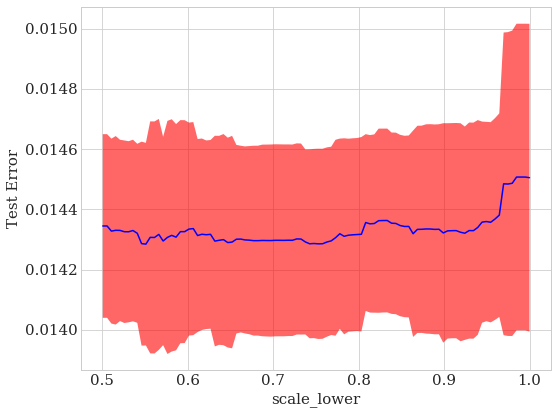

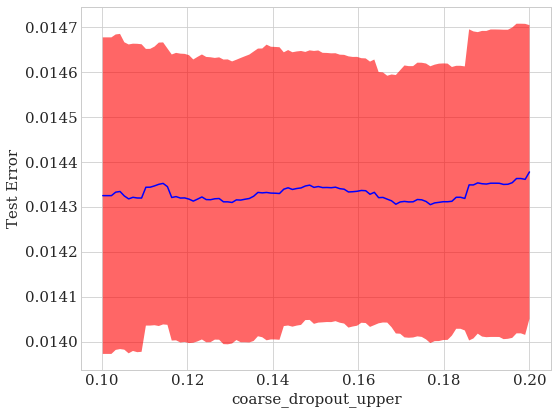

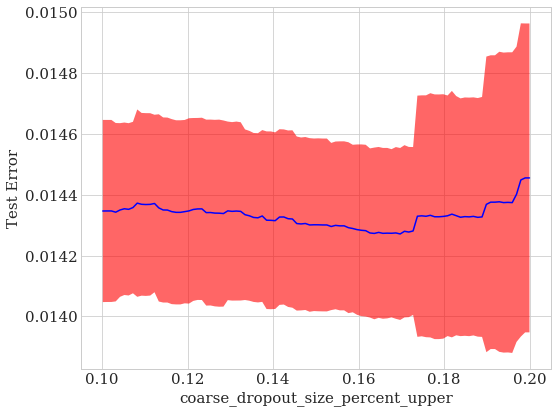

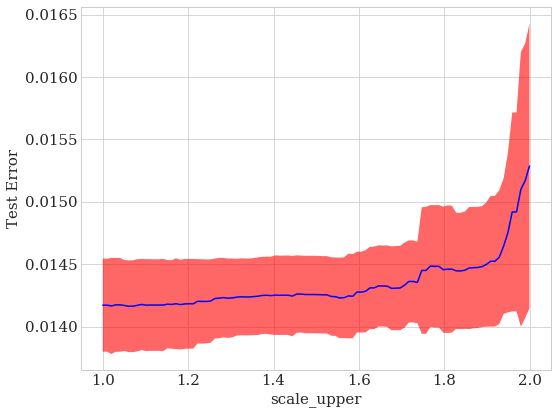

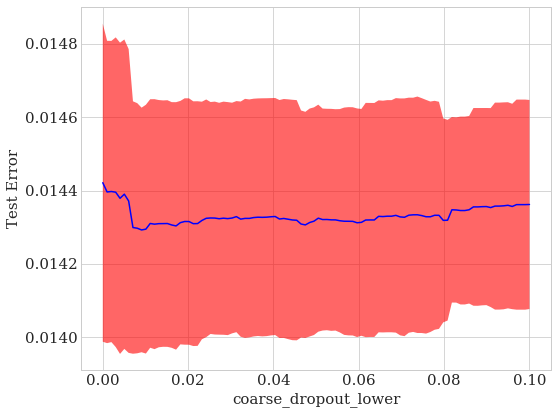

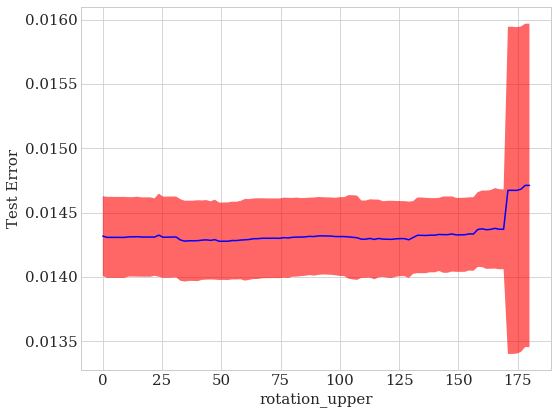

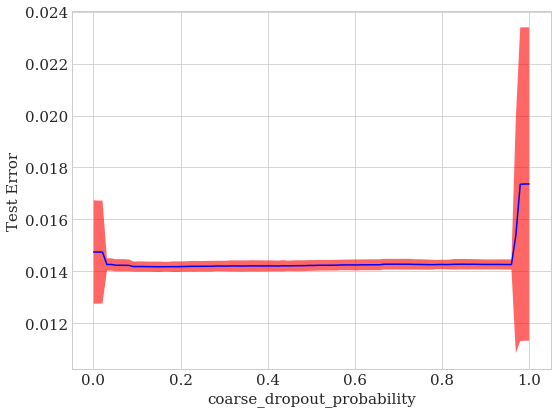

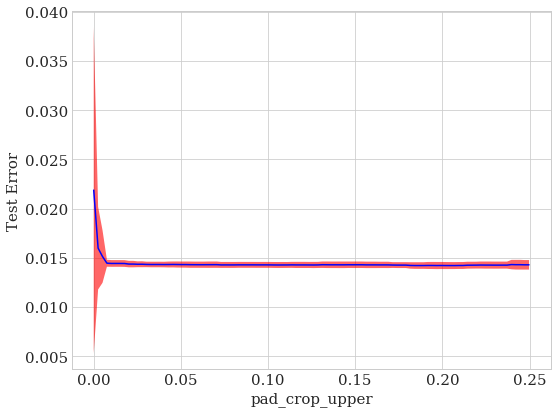

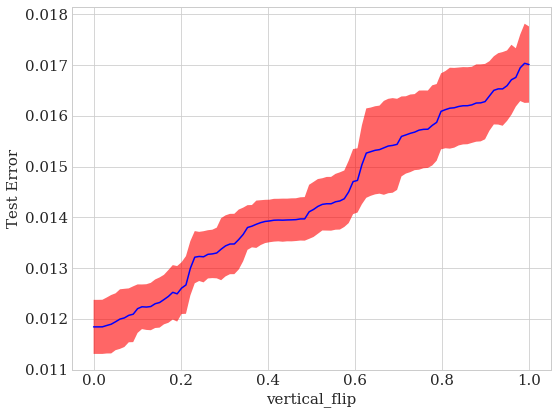

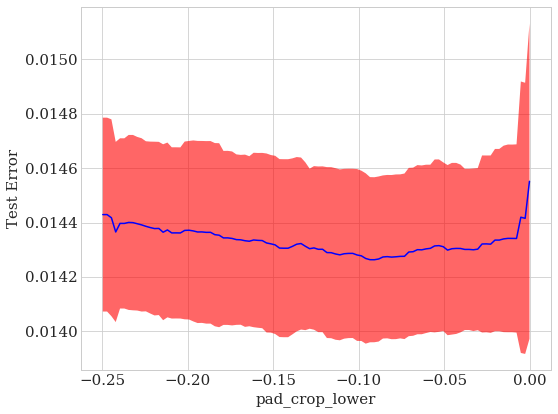

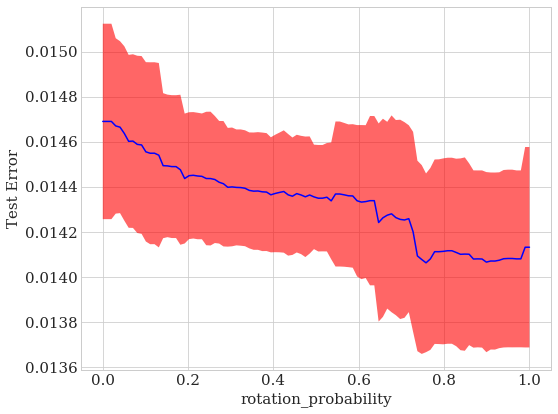

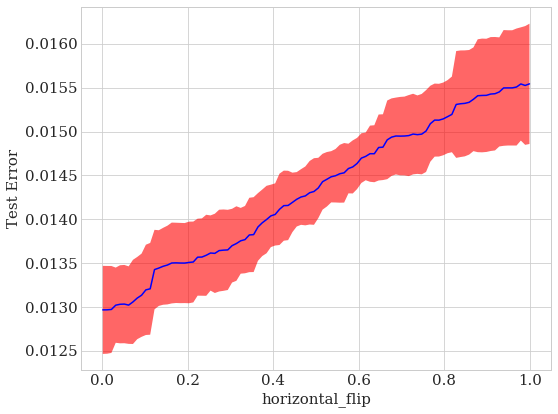

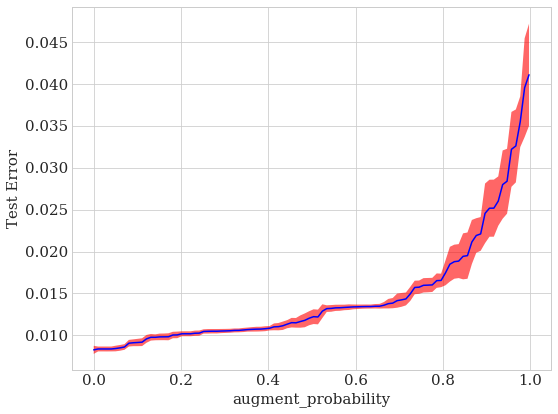

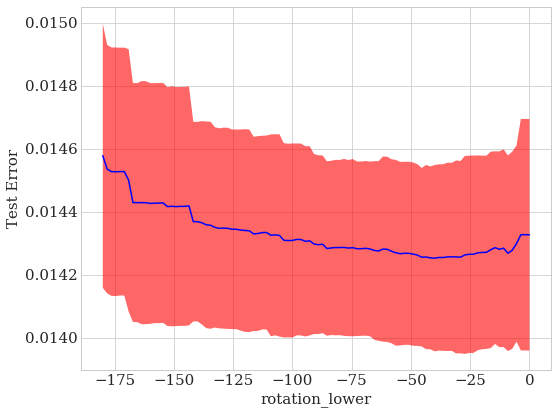

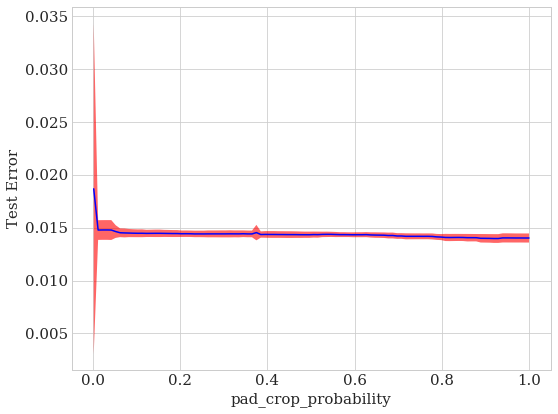

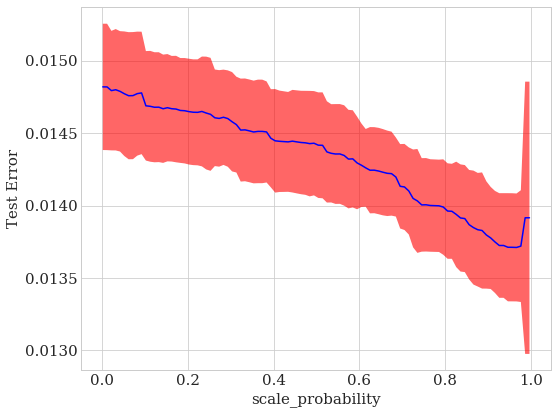

In [16]:
import sys
import os
import pandas as pd
from os.path import abspath, join as path_join
import numpy as np

import json
import seaborn as sns
PARENT_DIR =  path_join(os.getcwd(), "..", "..")
print(PARENT_DIR)
sys.path.insert(0, PARENT_DIR)

from itertools import product
from glob import glob
from collections import OrderedDict
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.ticker import FormatStrFormatter
import ConfigSpace as CS
#from autoda.data_augmentation import ImageAugmentation
from fanova import fANOVA
from fanova import visualizer



sns.set_style(style='whitegrid')


plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('font', size=15.0, family='serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# READ DATA
path = path_join(abspath("."), "..", "..", "AutoData")
print("path", path)
msg = "Results to plot do not exist. Check path. {}".format(path)
assert os.path.exists(path), msg

order = ["coarse_dropout_size_percent_lower" , "scale_lower" , "coarse_dropout_upper",
         "coarse_dropout_size_percent_upper", "scale_upper", "coarse_dropout_lower",
         "rotation_upper", "coarse_dropout_probability", "pad_crop_upper", "vertical_flip",
         "pad_crop_lower", "rotation_probability", "horizontal_flip", "augment_probability", 
         "rotation_lower", "pad_crop_probability", "scale_probability"
]

benchmarks = ["LeNet", "AlexNet"]
optimizers = ("BOHB",)
datasets = ("mnist", "cifar10", "cifar100",)

marker="random"

def read_data(dataset, benchmark="AlexNet", marker="random"):
    base_path = path_join(path, dataset, "random", benchmark)
    filenames = glob("{base_path}/{marker}*{dataset}*.json".format(base_path=base_path, marker=marker, dataset=dataset))
    #print(filenames)
    
    def read_files(filenames):
        data = {}
        test_error = []
        configs=[]
        for filename in filenames:
            with open(filename, "r") as f:
                json_content = json.load(f)
                test_error.append(json_content["test_error"])
                configs.append(json_content["configs"])
                data["configs"] = configs
                data["test_error"] = test_error
                #print(json_content)
            #print(data)
        return data
    data= read_files(filenames=filenames)
    return data

results = read_data(dataset="mnist", benchmark="LeNet")


# FANOVA PLOTS
X = []
for c in results["configs"]:
    vec = []
    for j, k in enumerate(order):
        if c[k] is not None: 
            vec.append(c[k])
            
        else:
            vec.append(0)
    X.append(vec)
X = np.array(X)
y = results["test_error"]

f = fANOVA(X, y)
output_directory = path_join(path, "plots/fanova/mnist")
vis = visualizer.Visualizer(f, f.cs, directory=output_directory)

for i in range(len(order)):
    plt = vis.plot_marginal(i, show=False)
    plt.xlabel(order[i])
    plt.ylabel("Test Error")
    plt.show()


In [ ]:
import ConfigSpace as CS
AUTODA_DIR =  path_join(os.getcwd(), "..", "..","AutoDA")
print(AUTODA_DIR)
sys.path.insert(0, AUTODA_DIR)

from autoda.data_augmentation import ImageAugmentation

b = results["configs"][0]
cs = ImageAugmentation.get_config_space()
incumbent = CS.Configuration(cs, values=b)
from smac.scenario.scenario import Scenario



scenario = Scenario({"run_obj": "quality",
                     "runcount-limit": 10000,
                     "cs": cs,
                     "deterministic": "true",
                     "initial_incumbent": "RANDOM",
                     "output_dir": ""})

print(scenario)

from pimp.pimp import PIMP
plt.rcParams['text.usetex'] =False

pimp = PIMP(scenario, X=X, y=y, mode=['lpi'], save_folder=output_directory)
pimp.imp.incumbent = incumbent
print(pimp.X.shape)
print(pimp.y.shape)

result = pimp.compute_importances()